For each connecting rod appearing in the image, the vision system should provide the following
information:
1. Type of rod (A or B).
2. Position and orientation (modulo pi).
3. Length (L), Width (W), Width at the barycenter (WB).
4. For each hole, position of the centre and diameter size.

1. Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”).
2. Rods can have contact points but do not overlap one to another.
3. The inspection area may be dirty due to the presence of scattered iron powder.

In [1]:
import os
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import collections
from statistics import mean
import random

import math
file_list = ['TESI00.BMP', 'TESI01.BMP', 'TESI12.BMP', 'TESI21.BMP', 'TESI31.BMP', 'Tesi33.bmp',
            'TESI44.BMP', 'TESI47.BMP', 'TESI48.BMP', 'TESI49.BMP', 'TESI50.BMP', 'TESI51.BMP',
            'TESI90.BMP', 'TESI92.BMP', 'TESI98.BMP']
m=0

In [2]:
path = os.path.join('/Users','corinnamarchili','Desktop','Progetto2','ispezione-bielle-immagini')
img_file = file_list[m]
m+=1
img_file = 'TESI50.BMP'
src = cv.imread(os.path.join(path, img_file), cv.COLOR_BGR2RGB)

Applying Gaussian smoothing to remove iron powder and imperfections, applying Otsu's thresholding method to binarize the image and make it independent of lighting conditions.

TESI50.BMP


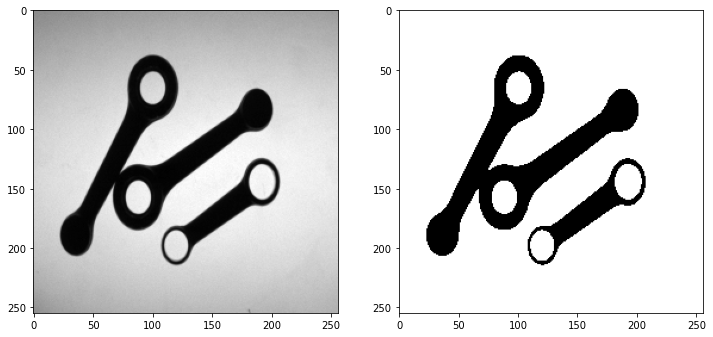

In [3]:
print(img_file)
blur = cv.medianBlur(src,3)
_,dst = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(src, cmap='gray')
axarr[1].imshow(dst, cmap='gray')
plt.show()

Finding connected components:

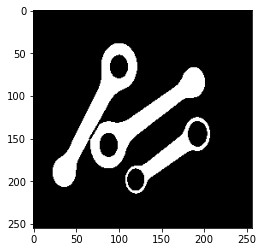

In [4]:
min_area = 1100
inverted = cv.bitwise_not(dst)
mask = np.zeros(inverted.shape, dtype="uint8")
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(inverted, 8) 
component_masks={}
j=0
#create a black background image to store the results
img = np.zeros(inverted.shape, dtype="uint8")


blob_x = collections.defaultdict(list)
contact_points_img = 0

for i in range(1, num_labels):
    x = stats[i, cv.CC_STAT_LEFT]
    y = stats[i, cv.CC_STAT_TOP]
    w = stats[i, cv.CC_STAT_WIDTH]
    h = stats[i, cv.CC_STAT_HEIGHT]
    area = stats[i, cv.CC_STAT_AREA]
    if(area >= min_area):
        componentMask = (labels == i).astype("uint8") * 255
        component_masks[j] = componentMask
        # look for defects in the separation by using the convex hull 
        copy = component_masks[j].copy()
        contours, hierarchy = cv.findContours(image=copy, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
        cnt = contours[0]
        hull = cv.convexHull(cnt, returnPoints=False)
        defects = cv.convexityDefects(cnt, hull)
        
        # separate touching rods
        contact_points = []

        THRESH_POINTS = 4000
        for n in range(defects.shape[0]):
            s,e,f,d = defects[n,0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            if(d > THRESH_POINTS):
                contact_points.append(far)
        for c in range(len(contact_points)):
            if(c%2==0):
                cv.line(copy, contact_points[c], contact_points[c+1], (0, 0, 0), thickness=2, lineType=cv.LINE_AA)
        blob_x['components'].append(copy)
                
        contact_points_img = contact_points_img + len(contact_points)
        j+=1
    
filtered_blobs = collections.defaultdict(list)
for blob in blob_x['components']:
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(blob, 8)
    for i in range(1, num_labels):
        x = stats[i, cv.CC_STAT_LEFT]
        y = stats[i, cv.CC_STAT_TOP]
        w = stats[i, cv.CC_STAT_WIDTH]
        h = stats[i, cv.CC_STAT_HEIGHT]
        area = stats[i, cv.CC_STAT_AREA]
        if(area >= min_area):
            componentMask = (labels == i).astype("uint8") * 255
            filtered_blobs['components'].append(componentMask)
        
if(len(filtered_blobs['components']) > (len(blob_x['components']))):
    for i in range(len(filtered_blobs['components'])):
        img = img + filtered_blobs['components'][i]
        final_blobs = filtered_blobs
else:
    for i in range(len(blob_x['components'])):
        img = img + blob_x['components'][i]
        final_blobs = blob_x

plt.imshow(img, cmap='gray')
plt.show()

Optional output vector (e.g. std::vector<cv::Vec4i>), containing information about the image topology. It has as many elements as the number of contours. For each i-th contour contours[i], the elements hierarchy[i][0] , hierarchy[i][1] , hierarchy[i][2] , and hierarchy[i][3] are set to 0-based indices in contours of the next and previous contours at the same hierarchical level, the first child contour and the parent contour, respectively. If for the contour i there are no next, previous, parent, or nested contours, the corresponding elements of hierarchy[i] will be negative. 

Blob 0 - type A
Coordinates of baricenter: (75, 112)
Orientation major axis: -0.48

Blob 1 - type A
Coordinates of baricenter: (125, 129)
Orientation major axis: 0.65

Blob 2 - type B
Coordinates of baricenter: (159, 168)
Orientation major axis: 0.65



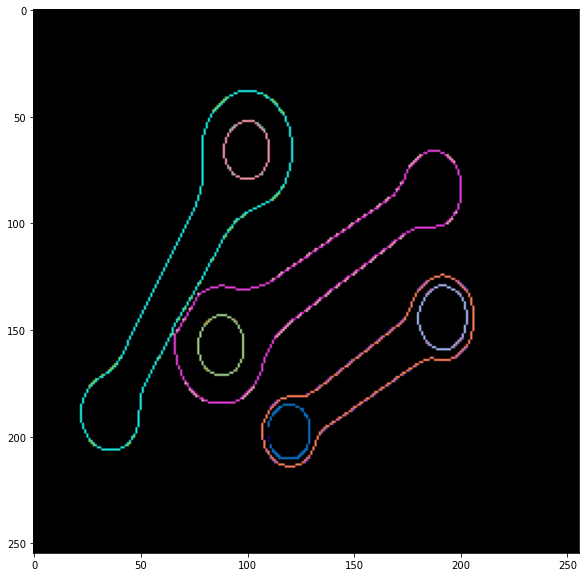

In [5]:
blob_details = collections.defaultdict(list)

circles = collections.defaultdict(list)
contours_voc = collections.defaultdict(list)
for index in range(0, len(final_blobs['components'])):
    blob = final_blobs['components'][index]
    count_holes = 0
    src = blob
    inverted = src
    blob = inverted.copy()
    threshold=100
    if contact_points_img == 0:
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))
        blob = cv.dilate(blob, kernel, iterations=1)      

    # Find internal contours to get information about circles
    canny_output = cv.Canny(blob, threshold, threshold * 2)
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    #Circles in a contour have a parent contour but not a son
    for i in range(len(contours)):
        if(hierarchy[0][i][2] == -1 and hierarchy[0][i][3] != -1):
            circles[index].append(contours[i])
            count_holes += 1
            
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        cv.drawContours(drawing, contours, i, color, 1, cv.LINE_8, hierarchy, 0)
    
    #Assign blob type
    if(count_holes > 1):
        type_rod = 'B'
    else:
        type_rod = 'A'
        
    print(f'Blob {index} - type {type_rod}')
    
    contours_ext, hierarchy = cv.findContours(image=blob, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    for i in range(len(contours_ext)):
        cnt = contours_ext[i]
        contours_voc['drawings'].append(drawing)

        mu = cv.moments(contours_ext[i])
        baricentre = (int(mu['m10'] / (mu['m00'] + 1e-5)), int(mu['m01'] / (mu['m00'] + 1e-5)))
        print('Coordinates of baricenter:', baricentre)
        tan_2 = (2 * mu['mu11']) / ( mu['mu20'] -  mu['mu02'])
        orientation_maj = -1/2 * np.arctan(tan_2) 
        orientation_min = -1/2 * np.arctan(tan_2) + math.pi/2
        print(f'Orientation major axis: {orientation_maj:.2f}')
        
        blob_details[index].append(cnt)
        blob_details[index].append(baricentre)
        blob_details[index].append(mu)
        blob_details[index].append((orientation_maj, orientation_min))

    print()
    
    
background = np.zeros((inverted.shape[0],inverted.shape[1], 3) , dtype="uint8")       
for element in contours_voc['drawings']:
    background = background + element

plt.figure(figsize=(10, 10))
plt.imshow(background, cmap='gray')
plt.show()

For each hole, position of the centre and diameter size.

In [6]:
print('Circle information - centre and radius')
print()

for k in circles.keys():
    for cont in circles[k]:
        rad = []
        mu = cv.moments(cont)
        bar = (int(mu['m10'] / (mu['m00'] + 1e-5)), int(mu['m01'] / (mu['m00'] + 1e-5)))
        if((bar[0] != 0) and (bar[1] != 0)):
            for p in cont:
                distance = math.sqrt((math.pow((bar[0] - p[0][0]),2))+(math.pow((bar[1] - p[0][1]),2)))
                rad.append(distance)
            radius = mean(rad)
            print(f'Blob {k}: centre {bar}, radius {radius:.2f}')

Circle information - centre and radius

Blob 0: centre (99, 65), radius 12.16
Blob 1: centre (87, 157), radius 12.49
Blob 2: centre (119, 200), radius 12.25
Blob 2: centre (191, 144), radius 12.85


Computation of image moments to get barycentre, orientation, length:

In [7]:
#Implementation of the algorithm from slide 46 of "Blob Analysis"
def compute_oriented_mer(aMA, bMA, cMA, aMI, bMI, cMI, cont):
    dMAmin=100000
    dMAmax=-100000
    dMImin=100000
    dMImax=-100000
    normMA = math.sqrt(math.pow(aMA,2)+math.pow(bMA,2))
    normMI = math.sqrt(math.pow(aMI,2)+math.pow(bMI,2))
    for e in cont:
        j = e[0][0]
        i = e[0][1]
        dMA = (aMA*j+bMA*i+cMA)/normMA
        dMI = (aMI*j+bMI*i+cMI)/normMI
        if(dMA < dMAmin):
            dMAmin = dMA
            C1 = (j,i)
        if(dMA > dMAmax):
            dMAmax = dMA
            C2 = (j,i)
        if(dMI < dMImin):
            dMImin = dMI
            C3 = (j,i)
        if(dMI > dMImax):
            dMImax = dMI
            C4 = (j,i)
    return C1, C2, C3, C4


In [8]:
def get_vertexes(C1, C2, C3, C4, aMA, bMA, aMI, bMI):
    j1, i1 = C1[0], C1[1]
    j2, i2 = C2[0], C2[1]
    j3, i3 = C3[0], C3[1]
    j4, i4 = C4[0], C4[1]

    cl1 = -(aMA*j1 + bMA*i1)
    cl2 = -(aMA*j2 + bMA*i2)
    cw1 = -(aMI*j3 + bMI*i3)
    cw2 = -(aMI*j4 + bMI*i4)
    
    v1 = (int((bMA*cw1 - bMI*cl1)/(aMA*bMI - bMA*aMI)),int((aMI*cl1 - aMA*cw1)/(aMA*bMI - bMA*aMI)))
    v2 = (int((bMA*cw2 - bMI*cl1)/(aMA*bMI - bMA*aMI)),int((aMI*cl1 - aMA*cw2)/(aMA*bMI - bMA*aMI)))
    v3 = (int((bMA*cw1 - bMI*cl2)/(aMA*bMI - bMA*aMI)),int((aMI*cl2 - aMA*cw1)/(aMA*bMI - bMA*aMI)))
    v4 = (int((bMA*cw2 - bMI*cl2)/(aMA*bMI - bMA*aMI)),int((aMI*cl2 - aMA*cw2)/(aMA*bMI - bMA*aMI)))
    return v1,v2,v3,v4

Blob 0 - lenght 182.02, width 44.29, width at barycentre 15.23
Blob 1 - lenght 161.40, width 50.61, width at barycentre 17.89
Blob 2 - lenght 119.81, width 36.40, width at barycentre 16.12


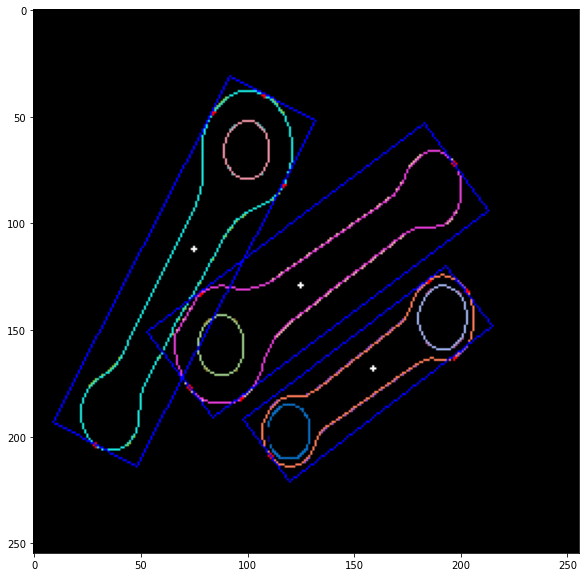

In [9]:
#blob_details is indexed by the blob and contains contour - baricentre - moments - (orientation_maj, orientation_min)
img_oer = background.copy()

for b in blob_details.keys():
    blob_contour = blob_details[b][0]
    blob_barycentre = blob_details[b][1]
    blob_moments = blob_details[b][2]
    blob_orientation = blob_details[b][3]
    
    cv.circle(img_oer, (blob_barycentre), radius=0, color=(255, 255, 255), thickness=2)

    
    #Compute alpha and beta from the orientation of the major axis
    alpha = -math.sin(blob_orientation[0])
    beta = math.cos(blob_orientation[0])
    
    aMA = alpha
    bMA = -beta
    cMA = beta*blob_barycentre[1] - alpha*blob_barycentre[0]
    
    aMI = beta
    bMI = alpha
    cMI = -beta*blob_barycentre[0] - alpha*blob_barycentre[1]
    
    C1, C2, C3, C4 = compute_oriented_mer(aMA, bMA, cMA, aMI, bMI, cMI, blob_contour)

    cv.circle(img_oer, C1, radius=0, color=(255, 0, 0), thickness=2)
    cv.circle(img_oer, C2, radius=0, color=(255, 0, 0), thickness=2)
    cv.circle(img_oer, C3, radius=0, color=(255, 0, 0), thickness=2)
    cv.circle(img_oer, C4, radius=0, color=(255, 0, 0), thickness=2)

    
    v1, v2, v3, v4 = get_vertexes(C1, C2, C3, C4, aMA, bMA, aMI, bMI)

    cv.line(img_oer, v1, v3, (0, 0, 255), 1)
    cv.line(img_oer, v1, v2, (0, 0, 255), 1)
    cv.line(img_oer, v2, v4, (0, 0, 255), 1)
    cv.line(img_oer, v4, v3, (0, 0, 255), 1)

    L = math.sqrt((math.pow((v1[0]-v2[0]),2))+(math.pow((v1[1]-v2[1]),2)))
    W = math.sqrt((math.pow((v1[0]-v3[0]),2))+(math.pow((v1[1]-v3[1]),2)))
    if(W > L):
        point1 = v1
        point2 = v2
    else:
        point1 = v1
        point2 = v3
    m = (point2[1]-point1[1])/(point2[0]-point1[0])
    c = blob_barycentre[1] - m*(blob_barycentre[0])
    distances = []
    for e in blob_contour:
        j = e[0][0]
        i = e[0][1]
        distance = math.sqrt((math.pow((blob_barycentre[0] - j),2))+(math.pow((blob_barycentre[1] - i),2)))
        distances.append(distance)
    wb = 2 * np.min(distances)

    print(f'Blob {b} - lenght {max(L,W):.2f}, width {min(L,W):.2f}, width at barycentre {wb:.2f}')
    
plt.figure(figsize=(10, 10))
plt.imshow(img_oer, cmap='gray')
plt.show()